In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
import seaborn as sns
import itertools

%matplotlib inline

warnings.filterwarnings('ignore')
np.random.seed(4)

from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten ,Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K

Using TensorFlow backend.


In [0]:
#Will be using  GPU to train the model as I'll give a significant boost in training time

In [3]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


GPU is properly configured and can now be used for training.
Using Nvidia Tesla K80 GPU

In [4]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [6]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train = pd.read_csv('/content/drive/My Drive/Dataset/MNIST/train.csv')
test = pd.read_csv('/content/drive/My Drive/Dataset/MNIST/test.csv')

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

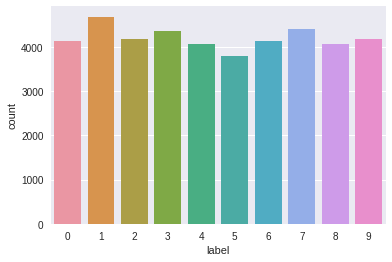

In [8]:
y = train['label']
X = train.drop(labels=['label'],axis=1)

del train #free space

#will check the distribution of various numerical labels
g = sns.countplot(y)

y.value_counts()

Counts are quite smiliar

In [9]:
X.isnull().any().any()

False

In [10]:
test.isnull().any().any()

False

It can be seen that test and train set have no missing values, we can safely go ahead to build our model

In [0]:
#Normalizing
#Nomalization increases convergance rate also reduces the effect of illiminance

X = X/255.0
test = test/255.0

In [0]:
#Reshaping
#as Keras requies 3rd dimension for channels
#Since dataset contains grayscale images it will have only one channel

X = X.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)


In [0]:
#Encloding labels

y =  to_categorical(y,num_classes=10)

In [0]:
#Splitting Data 

X_train,X_dev,y_train,y_dev = train_test_split(X,y,test_size=0.1,
                                               random_state = 4)

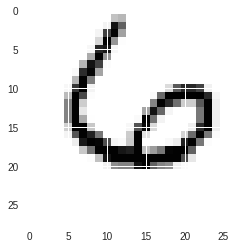

In [15]:
#visulazing a example

plt.imshow(X_train[1][:,:,0])

# Building Model

html
We will be using Keras sequential API and will add layers one-by-one sequentially.
Using 32 filters for first 2 layers and 64 for the last two<br>
Using dropout for regularization along with ReLU final layer will use sofmax activation function.

In [0]:
def build_model(fil1=32,fil2=64,activ='relu',drp=0.25):
  
  model = Sequential()
  model.add(Conv2D(filters=fil1, kernel_size=(5,5),padding='Same',
                  activation=activ , input_shape=(28,28,1)))
  model.add(Conv2D(filters=fil1, kernel_size=(5,5),padding='Same',
                  activation=activ))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(drp))
  
  model.add(Conv2D(filters=fil2,kernel_size=(3,3),padding='Same',
                  activation = activ))
  model.add(Conv2D(filters=fil2,kernel_size=(3,3),padding='Same',
                  activation = activ))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(drp))
  
  model.add(Flatten())
  model.add(Dense(256,activation = activ))
  model.add(Dropout(0.5))
  model.add(Dense(10,activation = 'softmax'))
  
  optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, 
                   decay=0.0, amsgrad=False)
  model.compile(optimizer=optimizer, loss ="categorical_crossentropy",
               metrics=['accuracy'])
  return model

In [0]:
# Set a learning rate annealer
lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.00001)

In [0]:
epochs = 4
batch_size = 64

In [19]:
X_train.shape

(37800, 28, 28, 1)

In [0]:
#Using data augumentation to avoid over-fitting
gendata = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
gendata.fit(X_train)

In [21]:
model = build_model()

cnn = model.fit_generator(gendata.flow(X_train,y_train,batch_size=batch_size),
                                      epochs=epochs,
                                      validation_data= (X_dev,y_dev),verbose=2,
                                      steps_per_epoch = X_train.shape[0],
                                      callbacks =[lr_reduction])

Epoch 1/4
 - 929s - loss: 0.0439 - acc: 0.9868 - val_loss: 0.0220 - val_acc: 0.9960
Epoch 2/4
 - 942s - loss: 0.0254 - acc: 0.9927 - val_loss: 0.0208 - val_acc: 0.9960
Epoch 3/4
 - 944s - loss: 0.0259 - acc: 0.9930 - val_loss: 0.0319 - val_acc: 0.9938
Epoch 4/4
 - 935s - loss: 0.0274 - acc: 0.9930 - val_loss: 0.0245 - val_acc: 0.9948

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


It can be seen that model's performance on train and dev set is quite similar also Bayes error for this particular problem is ~99.9 hence we can can that our model is performing quite well. 

Setting Epoch from 10-15 will yield an accuracy of around ~99.8 on Dev set, and will take a traning time of around 4 hours

**Evaluating Model's Performance**

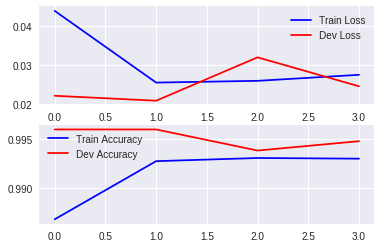

In [25]:
fig, ax = plt.subplots(2,1)
ax[0].plot(cnn.history['loss'],color= 'blue',label = 'Train Loss')
ax[0].plot(cnn.history['val_loss'],color= 'red',label = 'Dev Loss')
legend = ax[0].legend(loc='best')

ax[1].plot(cnn.history['acc'],color= 'blue',label = 'Train Accuracy')
ax[1].plot(cnn.history['val_acc'],color= 'red',label = 'Dev Accuracy')
legend = ax[1].legend(loc='best')

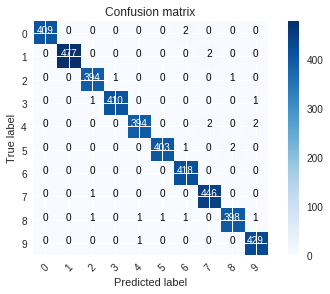

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_dev)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_dev,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

It can be seen that CNN have a very good performance on the Dev set in recognizing the images.

In [0]:
test_pred = model.predict(test)

test_pred = np.argmax(test_pred,axis=1)
test_pred = pd.Series(test_pred,name='Label')

In [0]:
submission = pd.concat([pd.Series(range(1,28001),name='ImageId'),
                        test_pred],axis=1)

submission.to_csv('MNIST_CNN_ADAMS.csv',index = False)